# Install and import libraries

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [1]:
!pip install -r req.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import os # for directory paths
import cv2 # data preproccessing
import tensorflow as tf # the AI library
import numpy as np # array stuff
from typing import List # type annotations
import matplotlib.pyplot as plt  # plotting stuff
import imageio # useful for videos

### enabling memmory growth

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-05-03 09:26:28.051630: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 09:26:28.080093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 09:26:28.080379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Loading data and building functions

In [4]:
import gdown

### Loading and Normalizing the values in them

In [3]:
def load_video(path:str) -> List[float]:
    # Initialize video capture object
    cap = cv2.VideoCapture(path)
    # Initialize an empty list to store frames
    frames = []
    # Iterate over each frame in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        # Read the next frame from the video
        ret, frame = cap.read()
        # Convert RGB frame to grayscale
        frame = tf.image.rgb_to_grayscale(frame)
        # Crop a specific region of interest within the frame
        cropped_frame = frame[190:236, 80:220, :]
        # Append the cropped frame to the list of frames
        frames.append(cropped_frame)
    # Release the video capture object
    cap.release()
    # Calculate the mean value of all frames
    mean = tf.math.reduce_mean(frames)
    # Calculate the standard deviation of the frames
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    # Normalize each frame by subtracting the mean and dividing by the standard deviation
    normalized_frames = tf.cast((frames - mean), tf.float32) / std
    # Return the list of normalized frames
    return normalized_frames

### Define vocab

In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789"]  # python list comprehension, it goes and iterates over each string specified as x and puts it as an element in the list

In [5]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

### creating the tokenizer

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9'] (size =39)


In [9]:
type(char_to_num), type(num_to_char)

(keras.src.layers.preprocessing.string_lookup.StringLookup,
 keras.src.layers.preprocessing.string_lookup.StringLookup)

In [10]:
test = [x for x in 'artin']

In [11]:
char_to_num(test)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 1, 18, 20,  9, 14])>

In [12]:
num_to_char(char_to_num(test))

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'a', b'r', b't', b'i', b'n'], dtype=object)>

### converting the alignments into a list of strings

In [13]:
test = [x for x in 'binblueatftwonow']
char_to_num(test)

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([ 2,  9, 14,  2, 12, 21,  5,  1, 20,  6, 20, 23, 15, 14, 15, 23])>

In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
load_alignments('data/alignments/s1/bbaf2n.align')

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14,  0,  2, 12, 21,  5,  0,  1, 20,  0,  6,  0, 20, 23, 15,
        0, 14, 15, 23])>

### Converting the video and the aligments to only have the mouth part of the video and tokenized alignments

In [10]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [17]:
test_path = os.path.join('data', 's1', 'bbal6n.mpg')

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [19]:
test_path

'data/s1/bbal6n.mpg'

In [20]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'data/s1/bbal6n.mpg'>

In [21]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [22]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.19734783],
         [ 0.07893913]],

        [[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209044 ],
         [ 1.4209044 ],
         [ 1.3814349 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.946331  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.86739

In [23]:
alignments.numpy()

array([ 2,  9, 14,  0,  2, 12, 21,  5,  0,  1, 20,  0, 12,  0, 19,  9, 24,
        0, 14, 15, 23])

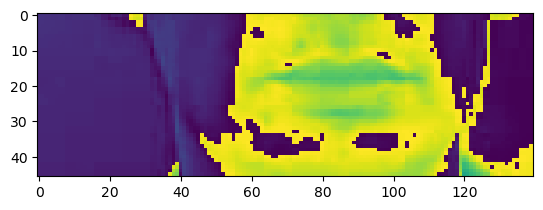

In [24]:
plt.imshow(frames[0])

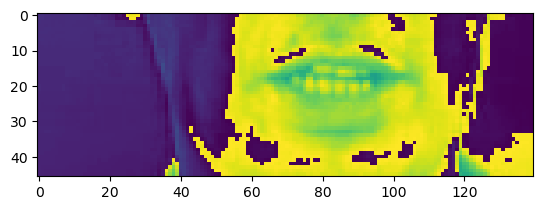

In [25]:
plt.imshow(frames[40])

In [26]:
tf.strings.reduce_join(num_to_char(alignments).numpy()).numpy()

b'binblueatlsixnow'

### Creating the mappble function

In [27]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', '', 'b', 'l', 'u', 'e', '', 'a', 't', '', 'l', '', 's', 'i', 'x', '', 'n', 'o', 'w']


In [28]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()], separator=' ').numpy()

b'b i n  b l u e  a t  l  s i x  n o w'

In [11]:
def mappable_function(path:str) ->List[str]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

# Creating the data pipeline

In [12]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[41]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [95]:
len(train), len(test)

(450, 50)

In [96]:
train.as_numpy_iterator().next()

(array([[[[[1.3565297 ],
           [1.3565297 ],
           [1.3931926 ],
           ...,
           [0.40329263],
           [0.3299667 ],
           [0.3299667 ]],
 
          [[1.2832038 ],
           [1.2832038 ],
           [1.3931926 ],
           ...,
           [0.40329263],
           [0.3299667 ],
           [0.3299667 ]],
 
          [[1.5031816 ],
           [1.5031816 ],
           [1.5398445 ],
           ...,
           [0.3299667 ],
           [0.3299667 ],
           [0.3299667 ]],
 
          ...,
 
          [[1.063226  ],
           [1.063226  ],
           [1.063226  ],
           ...,
           [0.        ],
           [0.        ],
           [0.07332593]],
 
          [[1.063226  ],
           [1.063226  ],
           [1.063226  ],
           ...,
           [0.14665186],
           [0.1099889 ],
           [0.1099889 ]],
 
          [[1.063226  ],
           [1.063226  ],
           [1.063226  ],
           ...,
           [9.312393  ],
           [9.312393  

In [97]:
frames, alignments = data.as_numpy_iterator().next()

In [98]:
frames.shape

(2, 75, 46, 140, 1)

In [99]:
alignments.shape

(2, 41)

In [36]:
tf.strings.reduce_join(num_to_char(alignments).numpy(), separator=' ').numpy()

b's e t  w h i t e  i n  u  f o u r  n o w                  b i n  g r e e n  w i t h  b  f o u r  n o w               '

In [37]:
frames, alignments = train.as_numpy_iterator().next()

In [38]:
frames.shape

(2, 75, 46, 140, 1)

In [39]:
alignments.shape

(2, 40)

In [40]:
len(alignments)

2

In [41]:
len(frames)

2

In [42]:
len(frames[1])

75

In [43]:
len(alignments[1])

40

In [44]:
sample = data.as_numpy_iterator()

In [45]:
val = sample.next(); val[0]

array([[[[[1.4942505 ],
          [1.4176223 ],
          [1.3793082 ],
          ...,
          [0.2298847 ],
          [0.2298847 ],
          [0.2298847 ]],

         [[1.4942505 ],
          [1.5325646 ],
          [1.3793082 ],
          ...,
          [0.2298847 ],
          [0.2298847 ],
          [0.2298847 ]],

         [[1.3793082 ],
          [1.3793082 ],
          [1.4559364 ],
          ...,
          [0.34482706],
          [0.30651292],
          [0.30651292]],

         ...,

         [[1.0344812 ],
          [1.0344812 ],
          [0.99616706],
          ...,
          [0.03831412],
          [0.        ],
          [0.        ]],

         [[1.0344812 ],
          [1.0344812 ],
          [0.99616706],
          ...,
          [0.        ],
          [9.7701    ],
          [9.7701    ]],

         [[1.0344812 ],
          [1.0344812 ],
          [0.99616706],
          ...,
          [0.        ],
          [9.7701    ],
          [9.7701    ]]],


        [[[1.3793

In [46]:
type(val[0][0])

numpy.ndarray

In [47]:
val[0][0].shape

(75, 46, 140, 1)

In [48]:
list = val[0][0]

In [49]:
list = tf.convert_to_tensor(list)

In [50]:
type(list)

tensorflow.python.framework.ops.EagerTensor

In [51]:
list =  tf.squeeze(tf.convert_to_tensor(list), axis=3)

In [52]:
list.shape

TensorShape([75, 46, 140])

In [53]:
imageio.mimsave('./animation.gif', list, fps=60)

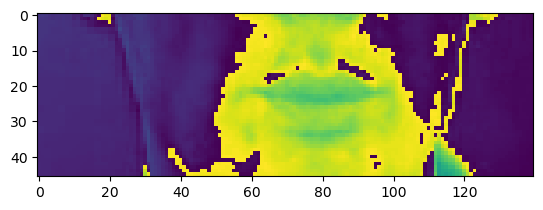

In [54]:
plt.imshow(val[0][0][35])

In [55]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]], separator=" ").numpy()

b'l a y  b l u e  b y  y  f o u r  p l e a s e               '

# Creating the neural network

### Importing the dependencies

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [14]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [15]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+2, kernel_initializer='he_normal', activation='softmax'))

In [16]:
char_to_num.vocabulary_size() + 1

40

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [18]:
yhat = model.predict(val[0])

NameError: name 'val' is not defined

In [62]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ccccccccccccccccccccccccppppppppccccccccccccccccccppppppppppppppppppppppppp'>

In [63]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ccccccccccccccccccccccccppppppppccccccccccccccccccppppppppppppppppppppppppp'>

In [106]:
model.input_shape

(None, 75, 46, 140, 1)

In [107]:
model.output_shape

(None, 75, 41)

### Set up training

In [19]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [20]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [21]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [22]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [23]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [24]:
schedule_callback = LearningRateScheduler(scheduler)

In [25]:
example_callback = ProduceExample(test)

In [74]:
!nvidia-smi

Fri May  3 09:40:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100S-PCIE-32GB          Off |   00000000:00:06.0 Off |                    0 |
| N/A   37C    P0             40W /  250W |    4591MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [84]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [85]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=3515b42c-a5d2-4dac-a9af-8b4eea8e25e1
To: /home/jovyan/checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:13<00:00, 6.98MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [26]:
model.load_weights('models/checkpoint')

In [27]:
test_data = test.as_numpy_iterator()

In [28]:
sample = test_data.next()

[mpeg1video @ 0x7f326007e900] ac-tex damaged at 22 17
[mpeg1video @ 0x7f326007e900] Warning MVs not available


In [29]:
yhat = model.predict(sample[0])

2024-05-03 10:51:49.701525: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 3s 3s/step


In [30]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'binblueatsonesoon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'setredbyofourplease'>]

In [31]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [32]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'binblueatsonesoon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'setredbyofourplease'>]

In [34]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [35]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'binredatsnineagain'>]

In [36]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 649ms/step


In [37]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [40]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'binredatsnineagain'>]

In [41]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'binredatsnineagain'>]